### This project aims to predict students' O level math scores based on certain baseline characteristics
#### Dataset obtained from AIAP SG PYS: https://github.com/aisingapore/AIAP-Technical-Assessment-Past-Years-Series

We will first clean the data, then do simple exploratory analysis before running a linear regression model and a random forest model to predict test scores.

### Description of attributes in the table:

|Attribute | Description |
| --- | --- |
|student_id | Unique ID for each student|
|number_of_siblings | Number of siblings|
|direct_admission |Mode of entering the school|
|CCA |Enrolled CCA|
|learning_style |Primary learning style|
|tuition |Indication of whether the student has a tuition|
|final_test |Student’s O-level mathematics examination score|
|n_male |Number of male classmates|
|n_female| Number of female classmates|
|gender |Gender type|
|age |Age of the student|
|hours_per_week |Number of hours student studies per week|
|attendance_rate |Attendance rate of the student (%)|
|sleep_time |Daily sleeping time (hour:minutes)|
|wake_time |Daily waking up time (hour:minutes)|
|mode_of_transport |Mode of transport to school|
|bag_color |Colour of student’s bag|

I postulate that the following variables will have a positive correlation with the O level math test scores:
1. Duration of sleep
2. Number of hours student studies per week
3. Attendance rate of the student
4. If the student has tuition
5. Male gender

I postulate that the following variables will have a negative correlation with the O level math test scores:
1. If the student is from a sports CCA
2. If the patient is from a direct_admission (i.e. not by grades but by other skills like sports)
3. Number of siblings
4. Number of classmates of the opposite gender

I postulate that the following variables will have no impact on O level math test scores:
1. Student's bag colour
2. Learning style
3. Mode of transport to school

In [356]:
#Access database

import sqlite3, pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from Ipython.display import display

#db_file = r"data\score.db"
db_file = r"score.db"
conn = None
try:
    conn = sqlite3.connect(db_file)
except sqlite3.Error as e:
    print(e)

In [357]:
#Find the Table Names in the database
query = '''
    SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
    '''
tables = pd.read_sql_query(query, conn)
tables

,name
0,score


In [358]:
#Load the score table into a DataFrame

query = '''
    SELECT * FROM score
    '''
df = pd.read_sql_query(query, conn)

In [359]:
df.shape

(15900, 18)

There are 18 observations and 18 variables in the score table

In [360]:
#Explore the score table
df.head()

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


Noted that there is an index column, without which, there are 16 independent variables and 1 dependent variable (final_test)

Let's drop the index column

In [361]:
df.drop(columns = 'index', inplace = True)

In [362]:
#Explore the score table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  15900 non-null  int64  
 1   direct_admission    15900 non-null  object 
 2   CCA                 15900 non-null  object 
 3   learning_style      15900 non-null  object 
 4   student_id          15900 non-null  object 
 5   gender              15900 non-null  object 
 6   tuition             15900 non-null  object 
 7   final_test          15405 non-null  float64
 8   n_male              15900 non-null  float64
 9   n_female            15900 non-null  float64
 10  age                 15900 non-null  float64
 11  hours_per_week      15900 non-null  float64
 12  attendance_rate     15122 non-null  float64
 13  sleep_time          15900 non-null  object 
 14  wake_time           15900 non-null  object 
 15  mode_of_transport   15900 non-null  object 
 16  bag_

"number of siblings" is the only integer variable among the numerical variables
And there a few columns with null values

In [363]:
#Explore the score table
df.describe()

,number_of_siblings,final_test,n_male,n_female,age,hours_per_week,attendance_rate
count,15900.000000,15405.000000,15900.000000,15900.000000,15900.000000,15900.000000,15122.000000
mean,0.886541,67.165401,13.880000,8.906038,15.213459,10.312579,93.270268
std,0.751346,13.977879,6.552584,6.663852,1.758941,4.461861,7.984230
min,0.000000,32.000000,0.000000,0.000000,-5.000000,0.000000,40.000000
25%,0.000000,56.000000,10.000000,4.000000,15.000000,7.000000,92.000000
50%,1.000000,68.000000,14.000000,8.000000,15.000000,9.000000,95.000000
75%,1.000000,78.000000,18.000000,13.000000,16.000000,14.000000,97.000000
max,2.000000,100.000000,31.000000,31.000000,16.000000,20.000000,100.000000


Of which 7 (not counting the index column) are quantitative variables

And looks like we have some outliers in the age column where the minimum cannot be negative, that's something to look out for

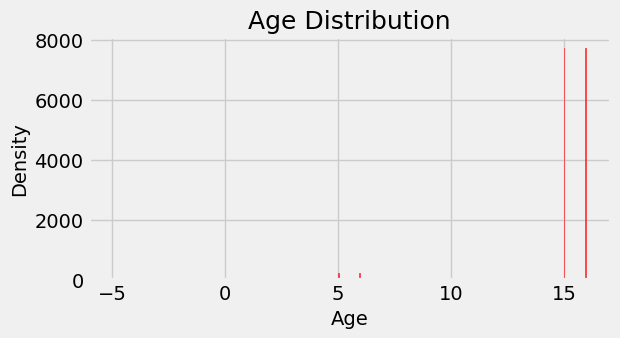

In [364]:

plt.figure(figsize=(6,3))
sns.histplot(df.age,color='r')
plt.title('Age Distribution',size=18)
plt.xlabel('Age',size=14)
plt.ylabel('Density',size=14)
plt.show()

Looks like most of the students are 15 and 16 years old. Let's see how many of them are not in this age range

In [365]:
from collections import Counter

count = Counter(df.age)
count

Counter({15.0: 7726, 16.0: 7723, 6.0: 230, 5.0: 216, -5.0: 4, -4.0: 1})

Looks like there are 2 groups of students, those 15-16yo and those 5-6yo. But since we are looking at O level math exam scores, it doesn't make sense for 5-6year olds to be taking these exams. It is more likely that these ages have been recorded wrongly with a missing 1 in front of them i.e. 5 year old should actually be 15 year old.

Hence, records with ages 5/6 will be amended to 15/16 respectively.

Records with Negative ages will be removed since they are insignficant (only 5 records out of 15.9k)

In [366]:
#Remove records with negative ages
df = df[df.age > 0]

In [367]:
#Amend records with ages 5/6
df.age = df.age.where(df.age > 6, other = df.age + 10)
count = Counter(df.age)
count

Counter({16.0: 7953, 15.0: 7942})

In [368]:
#Check for null values
df.isnull().sum()

number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
student_id              0
gender                  0
tuition                 0
final_test            495
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate       778
sleep_time              0
wake_time               0
mode_of_transport       0
bag_color               0
dtype: int64

Final_test and attendance_rate have null values, we will need to find a way to manage these null values

In [369]:
print('Ratio of null values in the final_test column: ', df['final_test'].isnull().sum()/df['final_test'].count())
print('Ratio of null values in the attendance_rate column: ', df['attendance_rate'].isnull().sum()/df['attendance_rate'].count())
print('Ratio of null values in any column: ', df.isnull().any(axis = 1).sum()/df.shape[0])

Ratio of null values in the final_test column:  0.03214285714285714
Ratio of null values in the attendance_rate column:  0.051465237811735134
Ratio of null values in any column:  0.07876690783265178


Since the number of rows with missing values < 10%, it is likely insignificant and i will be removing these rows

We will explore these after the main analysis

In [370]:
#Remove rows with null values
df = df[~df.isnull().any(axis = 1)]
df.isnull().sum() #check if it has been implemented correctly

number_of_siblings    0
direct_admission      0
CCA                   0
learning_style        0
student_id            0
gender                0
tuition               0
final_test            0
n_male                0
n_female              0
age                   0
hours_per_week        0
attendance_rate       0
sleep_time            0
wake_time             0
mode_of_transport     0
bag_color             0
dtype: int64

In [371]:
#Check for duplicates based on the student_id
df['student_id'].duplicated().sum()


763

Looks like there are some duplicates based on student ID (which are presumed to be unique to each student)

In [372]:
#check what the differences between the duplicate rows are
dup_ids = df['student_id'][df['student_id'].duplicated()]
df_dup = df[df['student_id'].isin(dup_ids)]
df_dup = df_dup.sort_values(by = 'student_id')
df_dup

,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
12290,0,No,Clubs,Auditory,00811H,Female,Yes,88.0,21.0,4.0,15.0,8.0,92.0,23:00,7:00,walk,white
5534,0,No,Clubs,Auditory,00811H,Female,Yes,88.0,21.0,4.0,15.0,8.0,92.0,23:00,7:00,walk,green
13541,1,No,Arts,Visual,0195IO,Female,No,52.0,8.0,22.0,16.0,15.0,99.0,22:00,6:00,private transport,yellow
12270,1,No,Arts,Visual,0195IO,Female,No,52.0,8.0,22.0,16.0,15.0,99.0,22:00,6:00,private transport,yellow
4303,0,No,Clubs,Auditory,02RSAH,Female,Yes,64.0,12.0,9.0,15.0,17.0,97.0,22:00,6:00,private transport,yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7511,0,No,None,Auditory,ZUGVXE,Female,No,67.0,24.0,3.0,16.0,9.0,91.0,21:30,5:30,public transport,red
9953,1,No,Arts,Auditory,ZZICEC,Female,Yes,54.0,11.0,13.0,15.0,12.0,93.0,22:00,6:00,private transport,blue
4429,1,No,Arts,Auditory,ZZICEC,Female,Yes,54.0,11.0,13.0,15.0,12.0,93.0,22:00,6:00,private transport,green
1241,0,No,None,Visual,ZZNA57,Male,No,72.0,23.0,5.0,16.0,13.0,95.0,21:30,5:30,public transport,green


Looks like we have some duplicates where the student has 2 different bag colours.

As bag colour would unlikely affect the student's score, we will just keep the last record of each student ID (assuming the later records are the most up-to-date)

In [373]:
#Remove duplicate rows of student ID
dup_ids = df['student_id'][df['student_id'].duplicated(keep = 'last')]
df = df[~df['student_id'].isin(dup_ids)]
print(df['student_id'].duplicated().sum()) #check if it has been implemented correctly

#Remove the student_ID column as a predictor
df.drop(columns = ['student_id'], inplace = True)


0


Now let's calculate the duration of sleep from sleep time and wake time

In [374]:
df['sleep_time'] = pd.to_datetime(df['sleep_time'],format = '%H:%M')
df['wake_time'] = pd.to_datetime(df['wake_time'],format = '%H:%M')
dur_sleep = df['wake_time'] - df['sleep_time']

hours = dur_sleep.dt.components.hours
mins = dur_sleep.dt.components.minutes

df['dur_sleep'] = hours + mins/60
df['dur_sleep'].unique() #checking if the data looks right

df.drop(columns = ['sleep_time','wake_time'], inplace = True)


Now let's create a new column for number of classmates of the opposite gender

In [375]:
df['n_oppgender'] = np.where(df['gender'] == 'Female', df['n_male'], df['n_female'])
df.head()

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,mode_of_transport,bag_color,dur_sleep,n_oppgender
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,private transport,yellow,8.0,14.0
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,private transport,green,8.0,4.0
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,private transport,white,8.0,2.0
5,0,No,Arts,Visual,Female,No,57.0,9.0,12.0,15.0,11.0,96.0,private transport,red,8.0,9.0
6,2,Yes,None,Visual,Male,No,69.0,12.0,3.0,16.0,15.0,93.0,public transport,green,8.0,3.0


In [376]:
#Looks like the transcribing is correct, let's remove the n_male and n_female columns
df.drop(columns = ['n_male','n_female'], inplace = True)

Now we will explore the distribution of the dependent variable

<Figure size 600x300 with 0 Axes>

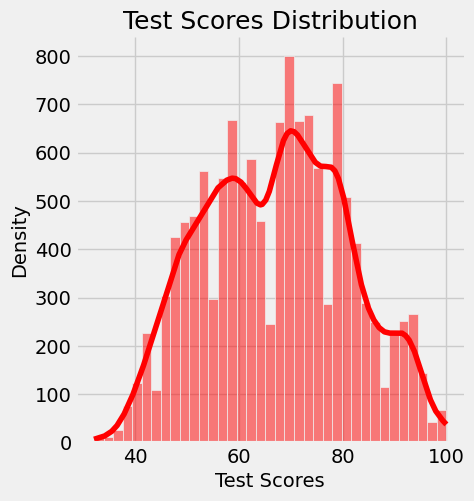

In [377]:
plt.figure(figsize=(6,3))
sns.displot(df.final_test,color='r', kde = True)
plt.title('Test Scores Distribution',size=18)
plt.xlabel('Test Scores',size=14)
plt.ylabel('Density',size=14)
plt.show()

Let's explor the histogram of the numerical values

C:\Users\User\AppData\Local\Temp\ipykernel_15832\3624823292.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[df.describe().columns].hist(ax=ax, color = "r")


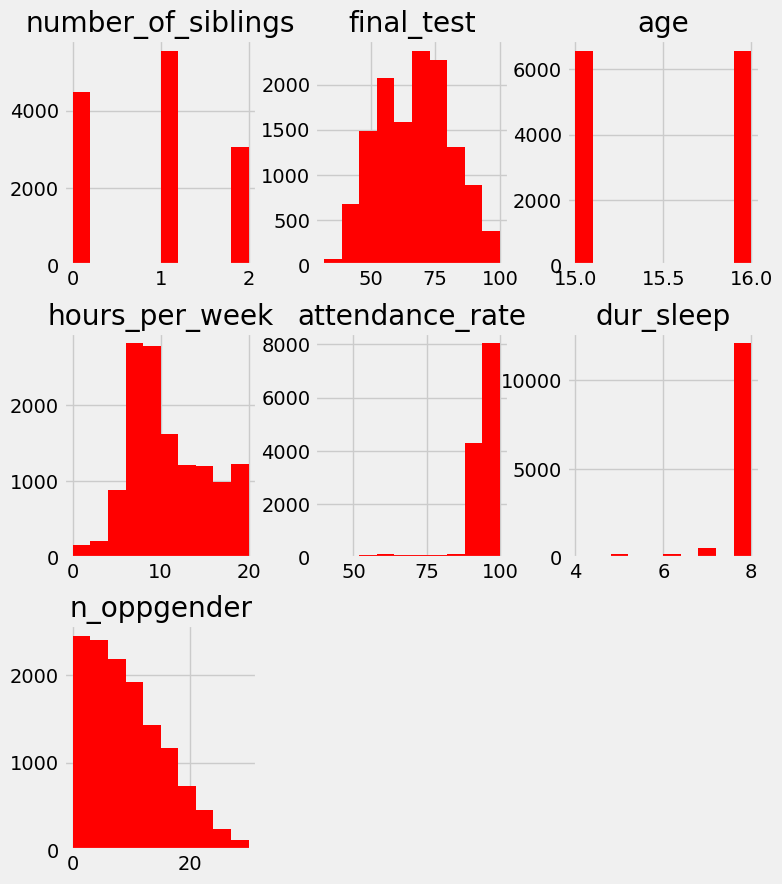

In [378]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,10))
ax = fig.gca()
df[df.describe().columns].hist(ax=ax, color = "r")
plt.show()

One key observation is that most of these predictors do not follow a normal distribution

Now we will explore pairplots of the numerical values

In [379]:
df.describe().columns

Index(['number_of_siblings', 'final_test', 'age', 'hours_per_week',
       'attendance_rate', 'dur_sleep', 'n_oppgender'],
      dtype='object')

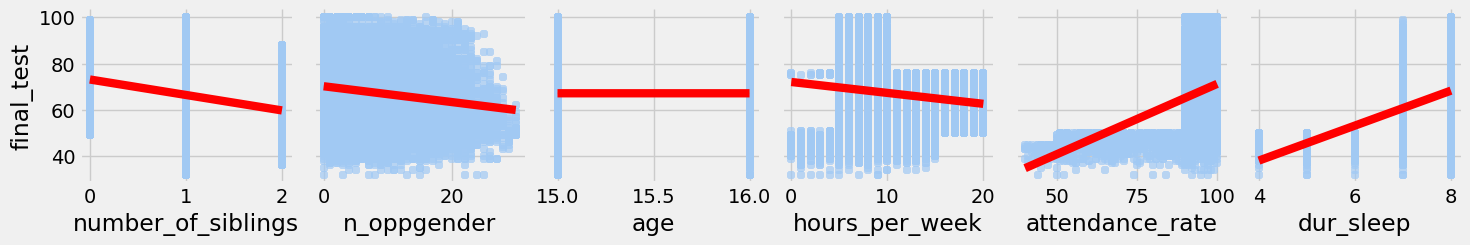

In [380]:
#less the index column
sns.set_palette("pastel")
sns.pairplot(df, 
                 y_vars = ['final_test'],
                 x_vars = ['number_of_siblings','n_oppgender','age', 'hours_per_week', 'attendance_rate','dur_sleep'],
                 markers="+",
                 diag_kind="kde",
                 kind='reg',
                 plot_kws={'line_kws':{'color':'red'}, 
                           'scatter_kws': {'alpha': 0.7}},
                );

At first impressions, it seems like there are relationships between final test scores with:
1. Number of siblings (inverse relationship)
2. Number of classmates of the opposite gender (inverse relationship)
3. Number of hours spent studying per week
4. The attendance rate
5. Duration of sleep

In [381]:
#Obtain the numeric columns less the final test column
numeric_columns = df.select_dtypes(np.number).columns
numeric_columns = [x for x in numeric_columns if x != "final_test"]
numeric_columns

['number_of_siblings',
 'age',
 'hours_per_week',
 'attendance_rate',
 'dur_sleep',
 'n_oppgender']

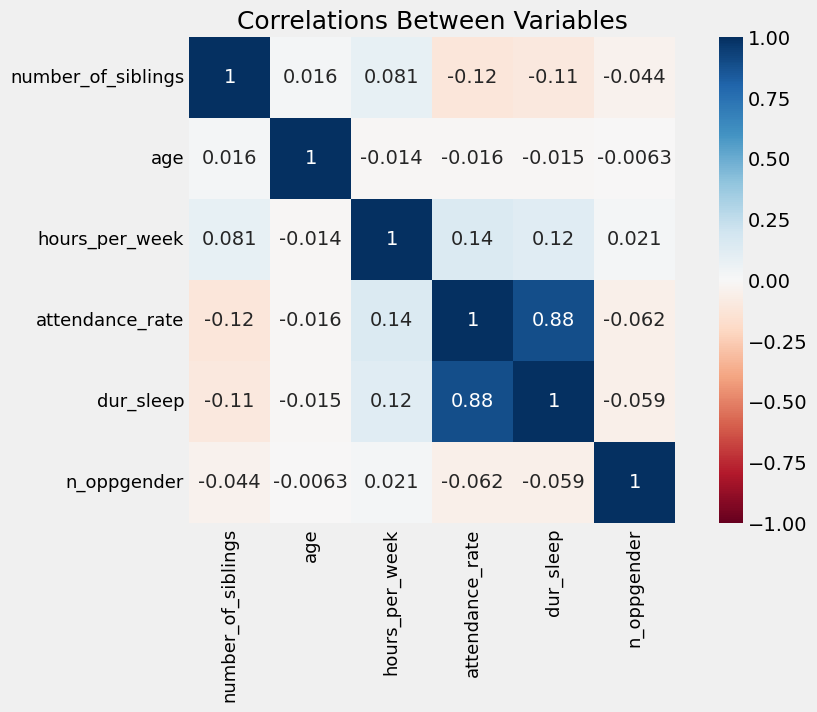

In [382]:
#Plot the correlation heatmap
plt.figure(figsize = (10,6))
sns.heatmap(df[numeric_columns].corr(),annot=True,square=True,
            cmap='RdBu',
            vmax=1,
            vmin=-1)
plt.title('Correlations Between Variables',size=18);
plt.xticks(size=13)
plt.yticks(size=13)
plt.show()

Looks like there's high positive correlation between attendance rate and duration of sleep.

Let's drop duration of sleep and use attendance rate as a predictor.

In [383]:
df.drop(columns = ['dur_sleep'], inplace = True)

In [384]:
#Obtain the numeric columns less the final test column
numeric_columns = df.select_dtypes(np.number).columns
numeric_columns = [x for x in numeric_columns if x != "final_test"]
numeric_columns

['number_of_siblings',
 'age',
 'hours_per_week',
 'attendance_rate',
 'n_oppgender']

We will now clean the categorical variables

In [385]:
#The categorical variables are:
cat_cols = [x for x in set(df.columns) - set(numeric_columns) if x != 'final_test']
cat_cols

['gender',
 'direct_admission',
 'CCA',
 'mode_of_transport',
 'tuition',
 'learning_style',
 'bag_color']

In [386]:
#And the unique variables are:
for c in df[cat_cols]:
    print(c,df[c].unique())

gender ['Female' 'Male']
direct_admission ['Yes' 'No']
CCA ['Sports' 'None' 'Arts' 'ARTS' 'Clubs' 'SPORTS' 'CLUBS' 'NONE']
mode_of_transport ['private transport' 'public transport' 'walk']
tuition ['No' 'Yes' 'Y' 'N']
learning_style ['Visual' 'Auditory']
bag_color ['yellow' 'green' 'white' 'red' 'blue' 'black']


In [387]:
#Standardise the Y to Yes and N to No for the tuition column
df['tuition'] = df['tuition'].replace(to_replace = {'Y':'Yes','N':"No"})

#Standardise the names of the CCA in the CCA column
df['CCA'] = df['CCA'].str.lower()

for c in df[cat_cols]:
    print(c,df[c].unique())


gender ['Female' 'Male']
direct_admission ['Yes' 'No']
CCA ['sports' 'none' 'arts' 'clubs']
mode_of_transport ['private transport' 'public transport' 'walk']
tuition ['No' 'Yes']
learning_style ['Visual' 'Auditory']
bag_color ['yellow' 'green' 'white' 'red' 'blue' 'black']


Looks like all categories are cleaned up, now to encode them. We will use one-hot encoding since there aren't too many categories per column, recognising that this might lead to multicollinearity. But the alternative of label encoding would be an issue since I'm planning to run a linear regression model. (ordinality is preserved even though there's no meaning to it). Binary encoding also adds an additional layer of complexity

In [388]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_data =  encoder.fit_transform(df[cat_cols])
df_cat_cols = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(cat_cols))

df.reset_index(drop = True, inplace = True)
df = pd.concat((df[df.columns[~df.columns.isin(cat_cols)]], df_cat_cols), axis = 1)


In [389]:
df.columns

Index(['number_of_siblings', 'final_test', 'age', 'hours_per_week',
       'attendance_rate', 'n_oppgender', 'gender_Female', 'gender_Male',
       'direct_admission_No', 'direct_admission_Yes', 'CCA_arts', 'CCA_clubs',
       'CCA_none', 'CCA_sports', 'mode_of_transport_private transport',
       'mode_of_transport_public transport', 'mode_of_transport_walk',
       'tuition_No', 'tuition_Yes', 'learning_style_Auditory',
       'learning_style_Visual', 'bag_color_black', 'bag_color_blue',
       'bag_color_green', 'bag_color_red', 'bag_color_white',
       'bag_color_yellow'],
      dtype='object')

We will drop one redundant column per category

In [390]:
df.drop(columns = ['tuition_No', 'learning_style_Auditory','bag_color_black','mode_of_transport_walk','CCA_none','direct_admission_No','gender_Female'], inplace = True)

In [391]:
df.head()

,number_of_siblings,final_test,age,hours_per_week,attendance_rate,n_oppgender,gender_Male,direct_admission_Yes,CCA_arts,CCA_clubs,CCA_sports,mode_of_transport_private transport,mode_of_transport_public transport,tuition_Yes,learning_style_Visual,bag_color_blue,bag_color_green,bag_color_red,bag_color_white,bag_color_yellow
0,0,69.0,16.0,10.0,91.0,14.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2,47.0,16.0,7.0,94.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,85.0,15.0,8.0,92.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,57.0,15.0,11.0,96.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2,69.0,16.0,15.0,93.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Now let's scale the data for ease of comparison later

In [392]:
from sklearn.preprocessing import MinMaxScaler #Using MinMaxScaler instead of StandardScaler since upper and lower boundaries are known. Furthermore, some of the values do not look like they follow a normal distribution

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

Now that the data is processed, we can start feeding the data into a few models and assess their performance

First, let's run the data through a linear regression model

In [393]:
dependent_col = ['final_test']
independent_col = [x for x in set(df.columns) - set(dependent_col)]

In [394]:
# Settings Train / Test Split. 
from sklearn.model_selection import train_test_split

# Splitting into Training and Holdout Test Sets
# Ensure stratification for now. We will adjust the ratio only later if required.
X_train, X_test, y_train, y_test = train_test_split(df[independent_col], df[dependent_col],\
                                                    stratify=df[dependent_col], test_size=0.2, random_state=121)

In [395]:
import statsmodels.api as st
X1 = st.add_constant(X_train)
lin_model=st.OLS(y_train,X1)
result=lin_model.fit()
print(result.summary2())

                          Results: Ordinary least squares
Model:                    OLS                   Adj. R-squared:          0.470      
Dependent Variable:       final_test            AIC:                     -10067.1864
Date:                     2024-04-24 22:36      BIC:                     -9922.0171 
No. Observations:         10493                 Log-Likelihood:          5053.6     
Df Model:                 19                    F-statistic:             490.9      
Df Residuals:             10473                 Prob (F-statistic):      0.00       
R-squared:                0.471                 Scale:                   0.022389   
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------------
const                                0.2993   0.0127  23.5534 0.0000  0.2744  0.3242
CCA_art

The P-value for age, bag_color and mode of transport are more than 0.05, hence we will remove them and rerun the linear regression

In [396]:
df.drop(columns = ['age','bag_color_white','bag_color_green','bag_color_red','bag_color_blue','bag_color_yellow','mode_of_transport_public transport','mode_of_transport_private transport'], inplace = True)

In [397]:
dependent_col = ['final_test']
independent_col = [x for x in set(df.columns) - set(dependent_col)]

# Settings Train / Test Split. 
from sklearn.model_selection import train_test_split

# Splitting into Training and Holdout Test Sets
# Ensure stratification for now. We will adjust the ratio only later if required.
X_train, X_test, y_train, y_test = train_test_split(df[independent_col], df[dependent_col],\
                                                    stratify=df[dependent_col], test_size=0.2, random_state=121)

import statsmodels.api as st
X1 = st.add_constant(X_train)
lin_model=st.OLS(y_train,X1)
result=lin_model.fit()
print(result.summary2())

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.470      
Dependent Variable:   final_test       AIC:                -10076.2637
Date:                 2024-04-24 22:36 BIC:                -9989.1621 
No. Observations:     10493            Log-Likelihood:     5050.1     
Df Model:             11               F-statistic:        847.4      
Df Residuals:         10481            Prob (F-statistic): 0.00       
R-squared:            0.471            Scale:              0.022386   
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                  0.2952   0.0118  25.1152 0.0000  0.2722  0.3183
number_of_siblings    -0.1553   0.0040 -39.0224 0.0000 -0.1631 -0.1475
CCA_arts              -0.1156   0.0043 -27.1548 0.0000 -0.1239 -0.1072
hours_per_week        -0.0

From the above linear regression, we can see that:

1) Attendance rate has the greatest impact on the student's O level math scores. If we recall earlier, duration of sleep is highly correlated with attendance rate. Hence it can be postulated that the most important predictor for a student's O level math score is duration of sleep which positively correlates with attendance rate and that naturally leads to higher math scores. It could be that duration of sleep has a direct impact on the math score as well.

2) Having a CCA (co-curricular activity) regardless of the type of CCA has a negative effect on the student's O level math scores.

3) Having a Visual as compared to Auditory learning style has a positive effect on the student's O level math scores

4) Naturally, coming from direct_admission into the school reflects a student's higher baseline ability and also correlates well with a higher O level math score.

5) Interestingly, having each additional sibling reduces the student's predicted math score by about 5. Presumably since the parent's resources need to be split among more children.

6) Also, interestingly, studying for longer actually reduces the students' math score. If we observe the pairwise plot earlier, this could be explained by the highest math scores coming from those who study between 5-10 hours a week. Any longer or shorter seems to correlate with lower scores.

7) Further, as expected, having a greater number of classmates of the opposite gender negatively affects O level math scores.

8) Lastly, gender doesn't affect the student's O level math scores by much even if it is a statistically significant predictor.

In [398]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [399]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Evaluate model on the test set
y_pred= model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Linear Regression R squared of the test set is: {:.2f}".format(r2_score(y_test, y_pred)))

print("Linear Regression MSE of the test set is: {:.2f}".format(mse))

lin_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("Linear Regression RMSE of the test set is: {:.2f}".format(lin_rmse))

print("Linear Regression MAE of the test set is: {:.2f}".format(mean_absolute_error(y_test, y_pred)))

Linear Regression R squared of the test set is: 0.44
Linear Regression MSE of the test set is: 0.02
Linear Regression RMSE of the test set is: 0.15
Linear Regression MAE of the test set is: 0.12


Let's now try using a randomforest model which is expected to perform better than a linear regression model. But might be more difficult to explain

In [400]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

c:\Users\User\Documents\GitHub\Projects\Python\AIAP_PYS\myenv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [401]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

In [402]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Evaluate model on the test set
mse = mean_squared_error(y_test, predictions)

print("Random Forest R squared of the test set is: {:.2f}".format(r2_score(y_test, predictions)))

print("Random Forest MSE of the test set is: {:.2f}".format(mse))

lin_rmse = np.sqrt(mean_squared_error(predictions, y_test))
print("Random Forest RMSE of the test set is: {:.2f}".format(lin_rmse))

print("Random Forest MAE of the test set is: {:.2f}".format(mean_absolute_error(y_test, predictions)))

Random Forest R squared of the test set is: 0.62
Random Forest MSE of the test set is: 0.02
Random Forest RMSE of the test set is: 0.13
Random Forest MAE of the test set is: 0.09


As expected, the random forest performs better than the linear regression model. 62% of the variance in the O level math scores can be explained by the variance in the predictors as compared to the linear regression's 44%. Furthermore, the error for the random forest model is lower regardless of which error metric is used.

Let's see what were the key predictors for the random forest model and how it compares to the linear regression model

In [403]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(independent_col, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: number_of_siblings   Importance: 0.24
Variable: hours_per_week       Importance: 0.21
Variable: attendance_rate      Importance: 0.19
Variable: n_oppgender          Importance: 0.11
Variable: direct_admission_Yes Importance: 0.09
Variable: learning_style_Visual Importance: 0.04
Variable: tuition_Yes          Importance: 0.04
Variable: CCA_arts             Importance: 0.02
Variable: gender_Male          Importance: 0.02
Variable: CCA_clubs            Importance: 0.02
Variable: CCA_sports           Importance: 0.01


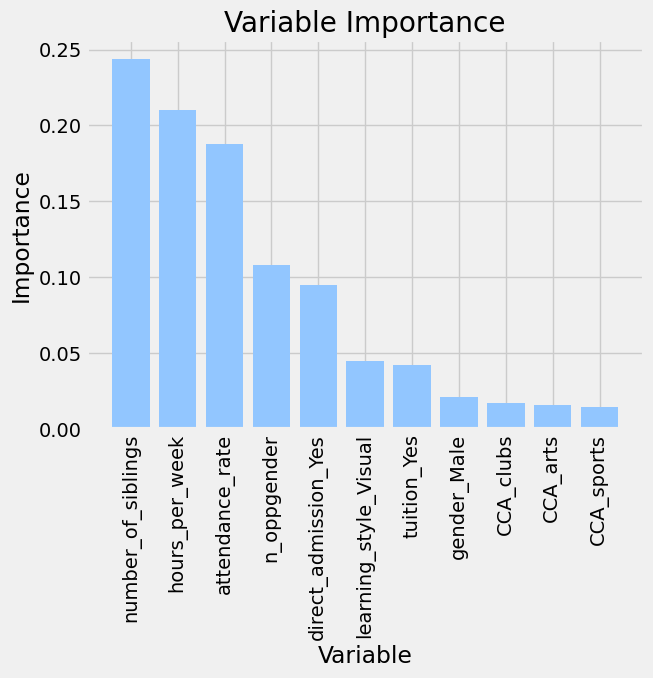

In [403]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('seaborn-v0_8-pastel')
# list of x locations for plotting
x_values = list(range(len(importances)))

#sort values by importance
i = sorted([(a,b) for a,b in zip(importances,independent_col)],key = lambda x:-x[0])
# Make a bar chart
plt.bar(x_values, [x[0] for x in i], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, [x[1] for x in i], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance');

Interestingly, in the random forest model, the importance of attendance rate drops and instead, number of hours studied per week and number of siblings the student is more important!

### Future research

In this analysis, only the O level math scores were used as the dependent variable, future research could be done to see if different subjects would lead to different results.

Furthermore, given that some of the relationships between the dependent and independent variables do not look linear, perhaps pre-treating the variables with either a logistic or boxcox transformation might help.

References:
1. https://www.sqlitetutorial.net/sqlite-python/sqlite-python-select/
2. https://medium.com/@ugursavci/complete-exploratory-data-analysis-using-python-9f685d67d1e4
3. https://medium.com/@dilip.voleti/multicollinearity-in-machine-learning-26d652b183de
4. https://medium.com/data-and-beyond/mastering-exploratory-data-analysis-eda-everything-you-need-to-know-7e3b48d63a95
5. https://medium.com/@redwaneaitouammi/11-predicting-house-prices-using-linear-regression-python-example-5697fff7f1a4
6. https://medium.com/@polanitzer/building-a-linear-regression-in-python-step-by-step-94caeb0a4f18
7. https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [404]:
#Other models which I didn't have time to complete

# From Standard Scaler for Numerical Columns (when necessary) Eg. Logistic Regression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_col = ['number_of_siblings','n_oppgender', 'hours_per_week', 'attendance_rate']

preprocessor = ColumnTransformer(\
    transformers=[('num', StandardScaler(), numeric_col)],\
    remainder='passthrough') # Pass through categorical features unchanged

X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=independent_col)
X_test_transformed = preprocessor.fit_transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=independent_col)
y_train_transformed = y_train.values.ravel()
y_test_transformed = y_test.values.ravel()